In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [18]:
mol = "SO2"
mol_path = f'./{mol}'
tables = '../tables'

In [4]:
pred_df = pd.read_csv(f'{tables}/pred_polar_{mol}.csv')
# x = pred_df/1000
# x.to_csv(f'../tables/{mol}_deriv.csv', index=False)
# pred_polar_time = pd.read_csv(f'../tables/CO2_time_polar.csv', sep=' ')
# pred_polar_time
# x
pred_df

,pred_polar_x,pred_polar_y,pred_polar_z
0,104.903813,98.203786,183.446503
1,104.095304,99.062766,183.863689
2,103.334730,99.971179,184.634593
3,102.619981,100.936012,185.666261
4,101.951559,101.966474,186.817578
...,...,...,...
16547,96.796023,112.515958,175.284848
16548,96.209574,113.653296,174.636014
16549,95.659204,114.887935,174.518938
16550,95.074352,116.149615,175.029576


In [5]:
if pred_df.pred_polar_x[0] > 1:
    pred_df = pred_df/1000
pred_df

,pred_polar_x,pred_polar_y,pred_polar_z
0,0.104904,0.098204,0.183447
1,0.104095,0.099063,0.183864
2,0.103335,0.099971,0.184635
3,0.102620,0.100936,0.185666
4,0.101952,0.101966,0.186818
...,...,...,...
16547,0.096796,0.112516,0.175285
16548,0.096210,0.113653,0.174636
16549,0.095659,0.114888,0.174519
16550,0.095074,0.116150,0.175030


In [29]:
try:
    time_df = pd.read_table(f'{mol_path}/time_temp_data_modif', sep='\s+', names=['time', 'temp'])
    new_time = time_df.time - time_df.time[0]
    print('Mean timestep', np.mean(np.diff(time_df.time)))
except:
    timestep = 0.0014
    new_time = pd.Series([round(timestep + timestep * i, 6) for i in range(pred_df.shape[0])], name='time')
    time_steps = new_time

In [9]:
def autocorrelation1(data):
    mean = np.mean(data)
    var = np.var(data)
    ndata = data - mean
    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr

In [11]:
pred_polar_time = pd.concat([new_time, pred_df], axis=1)
# pred_polar_time.to_csv(f'./CO2/CO2_time_polar.csv', index=False)
pred_polar_time

,time,pred_polar_x,pred_polar_y,pred_polar_z
0,0.0014,0.104904,0.098204,0.183447
1,0.0028,0.104095,0.099063,0.183864
2,0.0042,0.103335,0.099971,0.184635
3,0.0056,0.102620,0.100936,0.185666
4,0.0070,0.101952,0.101966,0.186818
...,...,...,...,...
16547,23.1672,0.096796,0.112516,0.175285
16548,23.1686,0.096210,0.113653,0.174636
16549,23.1700,0.095659,0.114888,0.174519
16550,23.1714,0.095074,0.116150,0.175030


In [25]:
deriv_x = pred_polar_time.iloc[:, :2]
deriv_x['deriv'] = deriv_x['pred_polar_x'].diff() / deriv_x['time'].diff()

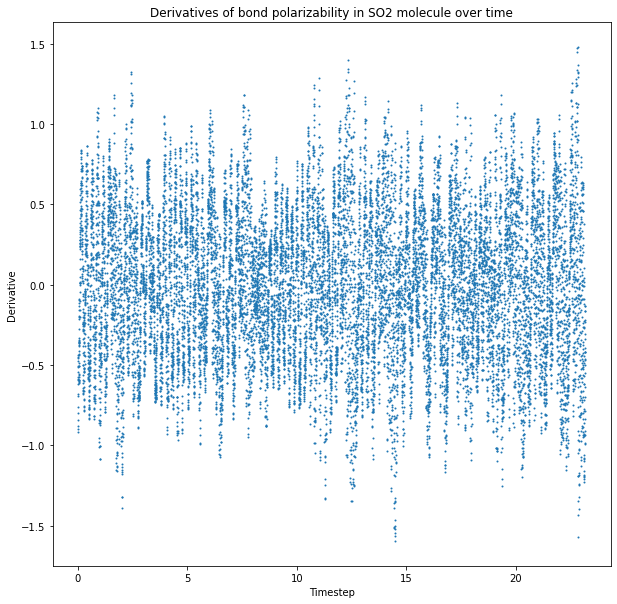

In [16]:
fig, ax = plt.subplots(figsize=(10,10));
scatter = ax.scatter(x=deriv_x.time, y=deriv_x.deriv, s=1);
# scatter = ax.scatter(x=time_steps, y=autocorr, s=0.5); ### For all axis polarization
plt.title(f"Derivatives of bond polarizability in {mol} molecule over time");
plt.ylabel('Derivative');
plt.xlabel('Timestep');
plt.show()

In [26]:
deriv_x.to_csv(f'{tables}/{mol}_deriv_x.csv', index=False)

In [34]:
# from scipy.signal import correlate
# sig = deriv_df.der[1:]
# corr = correlate(sig, sig, mode='full')
# corr = corr[len(corr)//2:]

# acorr1 = autocorrelation1(corr)

acorr = autocorrelation1(deriv_x.deriv[1:])

In [35]:
acorr1.shape

(16551,)

In [22]:
# timestep = 0.00145
# time_steps = [round(timestep + timestep * i, 6) for i in range(len(acorr1))]

In [37]:
df_acorr = pd.DataFrame({'timestep': time_steps[1:], 'acorr': acorr})
df_acorr

,timestep,acorr
1,0.0028,1.000000
2,0.0042,0.972724
3,0.0056,0.895541
4,0.0070,0.780650
5,0.0084,0.644807
...,...,...
16547,23.1672,0.000323
16548,23.1686,0.000255
16549,23.1700,0.000198
16550,23.1714,0.000142


In [42]:
df_acorr.to_csv(f'{tables}/{mol}_acorr_sep.csv', index=False, header=False, sep=' ')
# df_acorr.to_csv(f'{tables}/{mol}_acorr.csv', index=False)

'SO2'

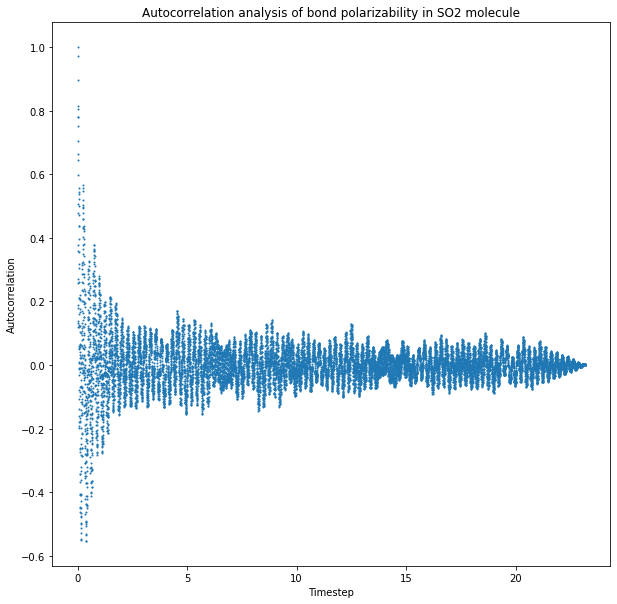

In [33]:
fig, ax = plt.subplots(figsize=(10,10));
# scatter = ax.scatter(x=df.timestep, y=df.deriv, s=0.5);
scatter = ax.scatter(x=deriv_x.time[1:], y=acorr1, s=1); ### For all axis polarization
plt.title(f"Autocorrelation analysis of bond polarizability in {mol} molecule");
plt.ylabel('Autocorrelation');
plt.xlabel('Timestep');
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10));
# # scatter = ax.scatter(x=df.timestep, y=df.deriv, s=0.5);
# scatter = ax.scatter(x=deriv_df.time[1:], y=acorr1, s=1); ### For all axis polarization
# plt.title(f"Autocorrelation analysis of bond polarizability in {mol} molecule");
# plt.ylabel('Autocorrelation');
# plt.xlabel('Timestep');
# plt.show()

In [11]:
# Global varibales

temp = 300
kb = 1.38064852E-23
reduced_planck = 1.05457180013E-34
lightspeed = 299792458

wavelen = 5.32E-7 #(nm -> m)
wavelen_nm = 532
# wavelen = 7.85E-7 #(nm -> m)
omega_in = 2 * np.pi * lightspeed / wavelen
# omega_in = 45.613245464 / wavelen
# timestep = 0.0012 ## ideally
timestep = 0.00145

In [ ]:
omega_in_2

In [ ]:
omega_in

In [16]:
from scipy.fftpack import fft, fftfreq

TO_CM_1 = 2 * np.pi * 100
size = df.shape[0]
# EXP_TERM = np.exp(-(omega_in * reduced_planck) / (kb * temp))

fft_autocorrelation = fft(df.deriv.values)[1:]
# fft_autocorrelation = np.fft.fft(df.deriv)


freqs_ps = np.fft.fftfreq(size, d=timestep)[1:]
freqs_cm1 = freqs_ps * TO_CM_1
freqs = freqs_cm1

# freqs = np.fft.fftfreq(size, d=timestep)[1:]
# freqs = fftfreq(size, d=timestep)[1:]


fft_autocorrelation = fft_autocorrelation / size


# raman_intensity = (
#     (omega_in - freqs) ** 4
#     / freqs
#     / (1 - np.exp(-(freqs * reduced_planck) / (kb * temp))) * np.real(fft_autocorrelation
# * np.exp(-1j * freqs * timestep)* timestep) 
# )

raman_intensity = (
    (omega_in - freqs) ** 4
    / freqs
    / (1 - np.exp(-(freqs * reduced_planck) / (kb * temp))) * fft_autocorrelation.real
)

NameError: name 'df' is not defined

In [17]:
from scipy.fftpack import fft, fftfreq

TO_CM_1 = 2 * np.pi * 100
size = deriv_df.shape[0] - 1

fft_autocorrelation = fft(acorr1)[1:]
# fft_autocorrelation = np.fft.fft(acorr1)


freqs_ps = np.fft.fftfreq(size, d=timestep)[1:]
freqs_cm1 = freqs_ps * TO_CM_1
freqs = freqs_cm1

# freqs = np.fft.fftfreq(size, d=timestep)[1:]
# freqs = fftfreq(size, d=timestep)[1:]


# fft_autocorrelation = fft_autocorrelation / size


# raman_intensity = (
#     (omega_in - freqs) ** 4
#     / freqs
#     / (1 - EXP_TERM) * np.real(fft_autocorrelation * np.exp(-1j * freqs * timestep)* timestep) 
# )

raman_intensity = (
    (omega_in - freqs) ** 4
    / freqs
    / (1 - np.exp(-(freqs * reduced_planck) / (kb * temp))) * fft_autocorrelation.real
)

In [ ]:
# raman_intensity = raman_intensity[len(raman_intensity)//2:]

# # Find the first low point
# d = np.diff(raman_intensity)
# start = np.nonzero(d > 0)[0][0]
# bias = 200
# peak = np.argmax(raman_intensity[(start+bias):]) + start
# peak

19998


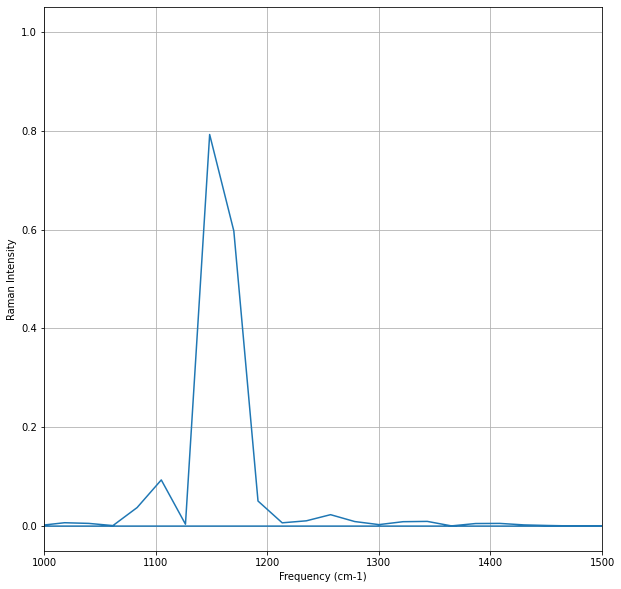

In [19]:
# plt.plot(lineshape_freq[:500], spectra_wm[:500])
# plt.plot(lineshape_freq[:20], spectra_wm[:20])

size = len(raman_intensity)
# size = 100

print(size)
raman_intensity = raman_intensity/ max(raman_intensity)
plt.figure(figsize=(10,10));
# plt.axvline(x=freqs[:size], ymax=raman_intensity[:size])
plt.plot(freqs[:size], raman_intensity[:size])
plt.xlabel("Frequency (cm-1)")
plt.ylabel("Raman Intensity")
# plt.xlim([-2000, 2000])
plt.xlim([1000, 1500])
# plt.xlim([0, 1400])
# plt.ylim([-0.1, 0.1])
plt.grid()
plt.show()
# plt.savefig('so2_raman_try.png')

In [ ]:
# import pyspt.fft as psfft

# # Your signal data
# signal = ...
# timesteps = ...  # Unevenly spaced timesteps

# # Perform FFT directly with time indices
# fft_result = psfft.fft(signal, t=timesteps)

# # Calculate frequencies based on actual timesteps
# freqs = 1.0 / np.diff(timesteps)

# # Select single-sided or double-sided representation as needed
# single_sided_freqs = freqs[:len(freqs)//2]
# single_sided_fft = fft_result[:len(freqs)//2]

In [ ]:
size = len(raman_intensity)
# size = 100

print(size)
raman_intensity = raman_intensity/ max(raman_intensity)
plt.figure(figsize=(10,10));
plt.plot(freqs[:size], raman_intensity[:size])
plt.xlabel("Frequency (cm-1)")
plt.ylabel("Raman Intensity")
# plt.xlim([-2000, 2000])
plt.xlim([1000, 1500])
# plt.xlim([0, 1400])
plt.ylim([-0.1, 0.1])
plt.grid()
plt.show()

In [ ]:
# tot_struct = df.shape[0]
# dt = 0.0015
# ac_data = df.deriv.values
# pi = math.pi
# h_k = 3.15775*100000
# w_in = omega_in
# freqs = []
# raman_list = []
# for k in tqdm(range(-tot_struct // 2, tot_struct // 2 + 1)):
#     sum_fourier_cos = 0.0
#     sum_fourier_sin = 0.0
#     if k != 0:
#         f = k / (tot_struct * dt)
#         wavenum = 33.333333 * f  # wavenumber in cm-1
#         w = 1.5204417e-4 * f  # in a.u.

#         for i in range(tot_struct):
#             sum_fourier_cos += ac_data[i] * np.cos(2 * pi * i * k / tot_struct)
#             sum_fourier_sin += ac_data[i] * np.sin(2 * pi * i * k / tot_struct)

#         integration = np.sqrt(sum_fourier_cos**2 + sum_fourier_sin**2)
#         exp_part = np.exp(-h_k * w / temp)
#         r = ((w_in - w)**4 / (w * (1 - exp_part))) * integration
#         raman_list.append(r)
#         freqs.append(w)

In [ ]:
# dt = 0.0015
# pi = np.pi
# h_k = 3.15775e5  # Adjusted for readability
# w_in = omega_in

# # Pre-calculate indices for efficiency
# indices = np.arange(-tot_struct // 2, tot_struct // 2)
# k_arr = indices[:, np.newaxis]  # Expand for broadcasting
# i_arr = np.arange(tot_struct)[:, np.newaxis]

# # Pre-calculate frequencies and wavenumbers
# frequencies = indices / (tot_struct * dt)
# wavenumbers = 33.333333 * frequencies
# angular_frequencies = 1.5204417e-4 * frequencies

# # Vectorized calculation of Fourier coefficients
# # coefficients = np.empty_like(frequencies, dtype=complex)
# # coefficients[k_arr != 0] = np.sum(
# #     ac_data[i_arr] * np.exp(-2j * pi * i_arr * k_arr / tot_struct), axis=1
# # )

# coefficients = np.empty((len(frequencies),), dtype=complex)  # Ensure 2D shape
# print(i_arr)
# # coefficients[k_arr != 0] = np.sum(
# #     ac_data[i_arr] * np.exp(-2j * pi * i_arr * k_arr / tot_struct), axis=1
# # )
# for index, wavenumber in tqdm(enumerate(frequencies)):
#     if wavenumber != 0:
#         try:
#             coefficients[index] = np.sum(
#                 ac_data * np.exp(-2j * pi * index * wavenumber / tot_struct)
#             )
#         except:
#             print(index)

# # Calculate spectral density using vectorized operations
# integrations = np.abs(coefficients)
# exp_parts = np.exp(-h_k * angular_frequencies / temp)
# mask = angular_frequencies != 0.0
# spectral_density = np.where(mask,
#                             ((w_in - angular_frequencies) ** 4 / (angular_frequencies * (1 - exp_parts))) * integrations,
#                             0.0)
# # spectral_density = (
# #     ((w_in - angular_frequencies) ** 4 / (angular_frequencies * (1 - exp_parts)))
# #     * integrations
# # )

In [ ]:
angular_frequencies[len(angular_frequencies)//2]

In [ ]:
# raman_intensity = raman_list
# size = len(raman_intensity)
# # size = 100
# raman_intensity = raman_intensity/ max(raman_intensity)
# new_freqs = 2 * 1000000 * np.array(freqs) * np.pi

# plt.figure(figsize=(10,10));
# plt.plot(new_freqs[:size], raman_intensity[:size])
# plt.xlabel("Frequency (cm-1)")
# plt.ylabel("Raman Intensity")
# # plt.xlim([-2000, 2000])
# # plt.xlim([1000, 1500])
# plt.xlim([0, 1000])
# # plt.ylim([-0.5, 0.5])
# plt.grid()
# plt.show()

In [ ]:
time_df = pd.read_table('../tables/time_temp_data_modif', sep='\s+', names=['time', 'temp'])
new_time = time_df.time - time_df.time[0]

In [ ]:
time_diffs = np.diff(time_df.time)
mean_diff = np.mean(time_diffs)

In [ ]:
pred_polar_time = pd.concat([new_time, new_pred_df], axis=1)
pred_polar_time.to_csv(f'../tables/CO2_time_polar.csv', sep=' ', index=False)

In [ ]:
from scipy.fftpack import fft, fftfreq

TO_CM_1 = 2 * math.pi * 100
size = df.shape[0]
EXP_TERM = np.exp(-(omega_in * reduced_planck) / (kb * temp))

fft_autocorrelation = fft(df.autocorr.values)[1:]

freqs_ps = np.fft.fftfreq(size, d=timestep)[1:]
freqs = freqs_ps * TO_CM_1

fft_autocorrelation = fft_autocorrelation / size
raman_intensity = (
    (omega_in - freqs) ** 4
    / freqs
    / (1 - EXP_TERM) * fft_autocorrelation.real
)